In [1]:
#Importing libraries

import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, Flatten, MaxPool2D, Input, Dropout, Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from keras.utils import to_categorical
from keras.optimizers import Adam
import os
from pathlib import Path
import glob
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import time

Using TensorFlow backend.


In [2]:
# #Unzip the dataset
# member = ('../GarbageClassification/garbage-classification.zip')
# from zipfile import ZipFile
# with ZipFile(member, 'r') as zipObj:
#        # Extract all the contents of zip file in current directory
#     zipObj.extractall()
 

In [3]:
#Reading the data
member = ('../GarbageClassification/Garbage classification/Garbage classification/')
catagories = os.listdir(member)
list_items = []
for cat in catagories:
    catagory_img = (member  + cat)
    #catagory_img.glob('*.jpeg')
    for _ in (glob.glob(catagory_img +'/'+'*.jpg')):
        list_items.append([cat, _])
    

In [4]:
data = pd.DataFrame(list_items,columns = ['catagory', 'filepath'], index = None)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)
data.shape

(2527, 2)

In [5]:
data.shape

train_data = data[1:1600]
val_data = data[1601:2000]
test_data = data[2001:2527]

In [6]:
# #Normalizing the images

# #Resizing the images
# def display_normal(a, title1 = 'Original'):
#     plt.imshow(a), plt.title(title1)
#     plt.show()
    
# def display(a,b, title1 = 'Original', title2 = 'Edited'):
#     plt.subplot(121), plt.imshow(a), plt.title(title1)
#     plt.subplot(122), plt.imshow(a), plt.title(title2)
#     plt.show()
    
# #Preprocessing images
# def preprocessing(data):
#     #loading images
#     #Getting 3 images to work with
#     img = [cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in data['filepath'].iloc[1:4]]
#     print(type(img))
#     print('Original Size: ', img[1].shape)
    
#     #--------------------------------------------
    
#     #Setting dim to resize
#     height = 220
#     width = 220
    
#     dim = (width, height)
#     res_img =[]
#     for i in range(len(img)):
#         res = cv2.resize(img[i], dim, interpolation = cv2.INTER_LINEAR)
#         res_img.append(res)
        
#     #Checking the resized image
    
#     print('Resized', res_img[1].shape)
    
#     #------------------------------------------------------------
    
#     #Removing noise from image - Gaussian blur
    
#     blurred_imgs =[]
    
#     for i in range(len(res_img)):
#         blurred_img = cv2.GaussianBlur(res_img[i], (5,5),0)
#         blurred_imgs.append(blurred_img)
        
#     #Segmentation 
#     #------------------------------------------------------------------
#     image = blurred_imgs[0]
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     ret,thresh = cv2.threshold(gray, 0,255,cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
    
#     #More noise removal
#     #------------------------------------------------------------------
#     kernal = np.ones((3,3), np.uint8)
#     opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernal, iterations=2)
    
#     #Sure background area
#     sure_bg = cv2.dilate(opening, kernal, iterations = 3)
    
#     #Finding foreground area
#     dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
#     ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    
#     # Finding unknown region
#     sure_fg = np.uint8(sure_fg)
#     unknown = cv2.subtract(sure_bg, sure_fg)
    
#     #Seperating different objects with different backgrounds
#     #Markers labelling
#     ret, markers  = cv2.connectedComponents(sure_fg)
#     #Add one to all labels so that sure background is 0 not 1
#     markers = markers+1
    
#     #Mark the unknown region with 0
#     markers[unknown == 255] = 0
    
#     markers = cv2.watershed(image, markers)
#     image[markers == -1] = [255,0,0]
    
#     #Displaying the markers on image
#     display_normal(markers)
    
#     #Displaying segmented back ground
#     display(thresh, sure_fg, 'Normal Thresh','Foreground area')
#     #Visualizing one of the image in the array
# #     original = image
# #     edited = blurred_img[0]
# #     display(image, thresh)
# #     display_normal(thresh)

In [7]:

#Preprocessing and duplication of images
def preprocessing(img):
    #Setting dim to resize
    height = 220
    width = 220
    pps_imgs = []
    dim = (width, height)
    #res_img = cv2.resize(cv2.imread(img, cv2.IMREAD_UNCHANGED), dim, interpolation = cv2.INTER_LINEAR)
    img = cv2.imread(str(img))
    res_img = cv2.resize(img, (224,224))
    if res_img.shape[2] ==1:
        res_img = np.dstack([res_img, res_img, res_img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255
    res_img = cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB)
    pps_imgs.append(res_img)

    #Removing noise from image - Gaussian blur

    blurred_img = cv2.GaussianBlur(res_img, (5,5),0)
    pps_imgs.append(blurred_img)
    
    #Segmentation 
    #------------------------------------------------------------------
    gray = cv2.cvtColor(res_img, cv2.COLOR_RGB2GRAY)
    ret,thresh = cv2.threshold(gray, 0,255,cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
    
    #More noise removal
    #------------------------------------------------------------------
    kernal = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernal, iterations=2)

    #Sure background area
    sure_bg = cv2.dilate(opening, kernal, iterations = 3)
    
    #Finding foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    #pps_imgs.append(ret)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    #Seperating different objects with different backgrounds
    #Markers labelling
    ret, markers  = cv2.connectedComponents(sure_fg)
    #Add one to all labels so that sure background is 0 not 1
    markers = markers+1
    #Mark the unknown region with 0
    markers[unknown == 255] = 0
    
    markers = cv2.watershed(blurred_img, markers)
    blurred_img[markers == -1] = [255,0,0]
    pps_imgs.append(markers)
    return pps_imgs

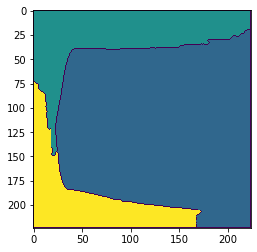

In [8]:
#Calling the function

imgs = preprocessing(data['filepath'].iloc[1])
for i in imgs:
    plt.imshow(i)
    time.sleep(5)
    

In [9]:
#Working on the model
def build_model():
    model = Sequential()
    input_size  = Input(shape = (255,255,3), name  =  'Input_Image')

    #Layer 1 - Deapth Layer 1
    x = Conv2D(64,(3,3), activation = 'relu', padding = 'same', name = 'ConvLayer1' )(input_size)
    x = MaxPool2D((2,2), name = 'Maxpool1')(x)

    #Layer 2 - Deapth layer 2
    x = Conv2D(128,(3,3), activation = 'relu', padding = 'same', name = 'ConvLayer2')(x)
    x = MaxPool2D((2,2), name = 'Maxpoo12')(x)
    x = Dropout(0.7, name = 'Dropout1')(x)
    #Layer 3 - Deapth layer 3
    x = Conv2D(256,(3,3), activation= 'relu',padding = 'same',  name = 'ConvLayer3')(x)
    x = MaxPool2D((2,2), name = 'Maxpool3')(x)

    #Flatten the model

    x = Flatten(name = 'Flatten')(x)

    x = Dense(256, activation = 'relu' ,name = 'FC1')(x)

    x = Dense(128, activation = 'relu', name = 'FC2')(x)
    x = Dropout(0.5, name = 'Dropout2')(x)
    x = Dense(6, activation = 'softmax', name = 'Fc3')(x)
    
    model = Model(input = input_size , output = x)
    return model

model = build_model()
model.summary()

In [10]:
model = build_model() 
model.summary()

W0302 21:42:04.680824 11484 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0302 21:42:04.705449 11484 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0302 21:42:04.705449 11484 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0302 21:42:04.730353 11484 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0302 21:42:04.753133 11484 deprecation_wrapper.py:119] From c:\programdata

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Image (InputLayer)     (None, 255, 255, 3)       0         
_________________________________________________________________
ConvLayer1 (Conv2D)          (None, 255, 255, 64)      1792      
_________________________________________________________________
Maxpool1 (MaxPooling2D)      (None, 127, 127, 64)      0         
_________________________________________________________________
ConvLayer2 (Conv2D)          (None, 127, 127, 128)     73856     
_________________________________________________________________
Maxpoo12 (MaxPooling2D)      (None, 63, 63, 128)       0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 63, 63, 128)       0         
_________________________________________________________________
ConvLayer3 (Conv2D)          (None, 63, 63, 256)       295168    
__________

c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("In..., outputs=Tensor("Fc...)`


In [11]:
#Fitting the model

opt = Adam(lr = 0.0001, decay = 1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath= 'bestmodel',save_best_only=True, save_weights_only=True)
model.compile(loss= 'binary_crossentropy', metrics= ['accuracy'], optimizer= opt)

W0302 21:42:04.933470 11484 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0302 21:42:04.954326 11484 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0302 21:42:04.961616 11484 deprecation.py:323] From c:\programdata\miniconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
